In [7]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error 

In [2]:
df = pd.read_excel('Base de données Sinodis.xlsx', sheet_name='Data', usecols=['Material', 'Sale Office', 'Billing Date', 'Quantité'])


In [8]:
df['Billing Date'] = pd.to_datetime(df['Billing Date'], format='%Y%m%d')

In [9]:
df_filtered = df[(df['Material'] == 'ELV0012') & (df['Sale Office'] == 'ShangHai')]

# Agréger les données par 'Billing Date' pour éliminer les doublons et calculer la somme des quantités
df_aggregated = df_filtered.groupby('Billing Date').agg({'Quantité': 'sum'}).reset_index()


In [10]:
min_date = df_aggregated['Billing Date'].min()
max_date = df_aggregated['Billing Date'].max()

# Créez une série temporelle continue des dates valides (quotidienne) entre la date minimale et maximale
date_range = pd.date_range(start=min_date, end=max_date, freq='D')

# Réindexer les données agrégées sur cette plage complète de dates
df_aggregated = df_aggregated.set_index('Billing Date').reindex(date_range).fillna(0).reset_index()

In [11]:
print(df_aggregated.head())  # Vérifiez les noms de colonnes après le réindexage


       index    Quantité
0 2021-01-02      47.472
1 2021-01-03       0.000
2 2021-01-04   18058.151
3 2021-01-05   81917.881
4 2021-01-06  102566.223


In [12]:
# Renommer les colonnes pour que l'index devienne 'ds' et la quantité 'y'
df_aggregated.rename(columns={'index': 'ds', 'Quantité': 'y'}, inplace=True)

# Conserver uniquement les colonnes nécessaires pour Prophet
df_aggregated = df_aggregated[['ds', 'y']]

In [13]:
# Initialiser le modèle Prophet
model = Prophet()

# Ajuster le modèle sur les données
model.fit(df_aggregated)

# Créer un DataFrame pour les futures prévisions (par exemple, les 30 prochains jours)
future = model.make_future_dataframe(periods=30, freq='D')

# Faire des prévisions
forecast = model.predict(future)

# Afficher les prévisions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))


14:08:59 - cmdstanpy - INFO - Chain [1] start processing
14:08:59 - cmdstanpy - INFO - Chain [1] done processing


             ds          yhat    yhat_lower     yhat_upper
1275 2024-06-30   6826.646628 -32621.518434   46925.702250
1276 2024-07-01  21705.834228 -17617.090983   62375.251699
1277 2024-07-02  54381.905868  12882.411600   96315.015723
1278 2024-07-03  53479.212882   9806.594882   93087.400580
1279 2024-07-04  49145.764363   9937.295475   94532.018651
1280 2024-07-05  69604.324125  28015.202945  110977.243582
1281 2024-07-06  45486.548681   6161.903439   89090.783528
1282 2024-07-07  11840.859744 -26549.422652   51420.916818
1283 2024-07-08  26744.022052 -14869.366862   67118.647821
1284 2024-07-09  59341.465159  16086.993363  102597.014770
1285 2024-07-10  58264.264389  17406.974174   95412.316817
1286 2024-07-11  53669.329991  12836.966694   92680.064596
1287 2024-07-12  73790.172029  35693.902380  113104.223626
1288 2024-07-13  49270.662321   8013.281748   90341.145801
1289 2024-07-14  15172.499368 -25677.806892   51550.275706
1290 2024-07-15  29586.360224 -11533.847474   68515.9972

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


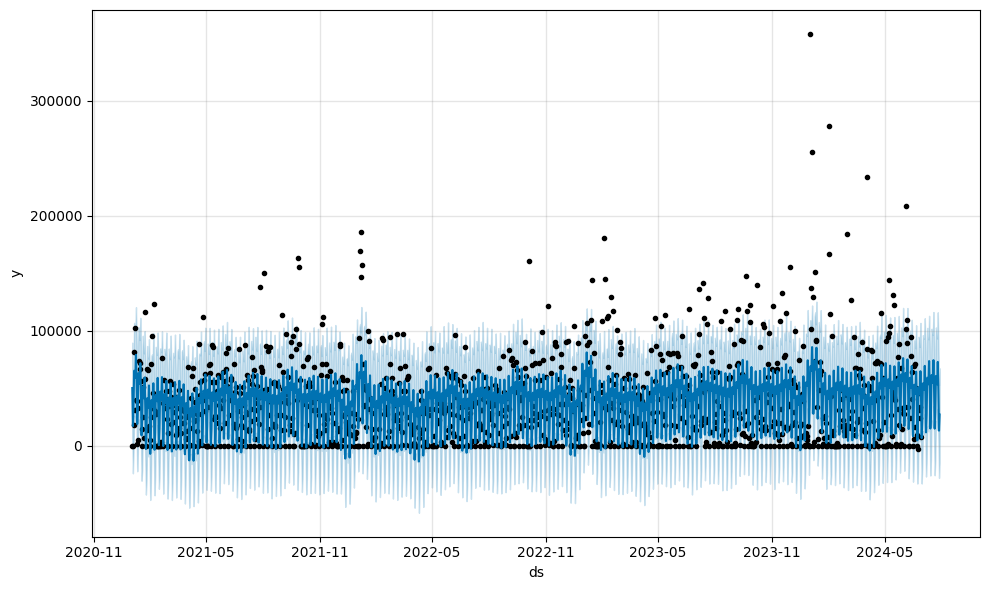

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

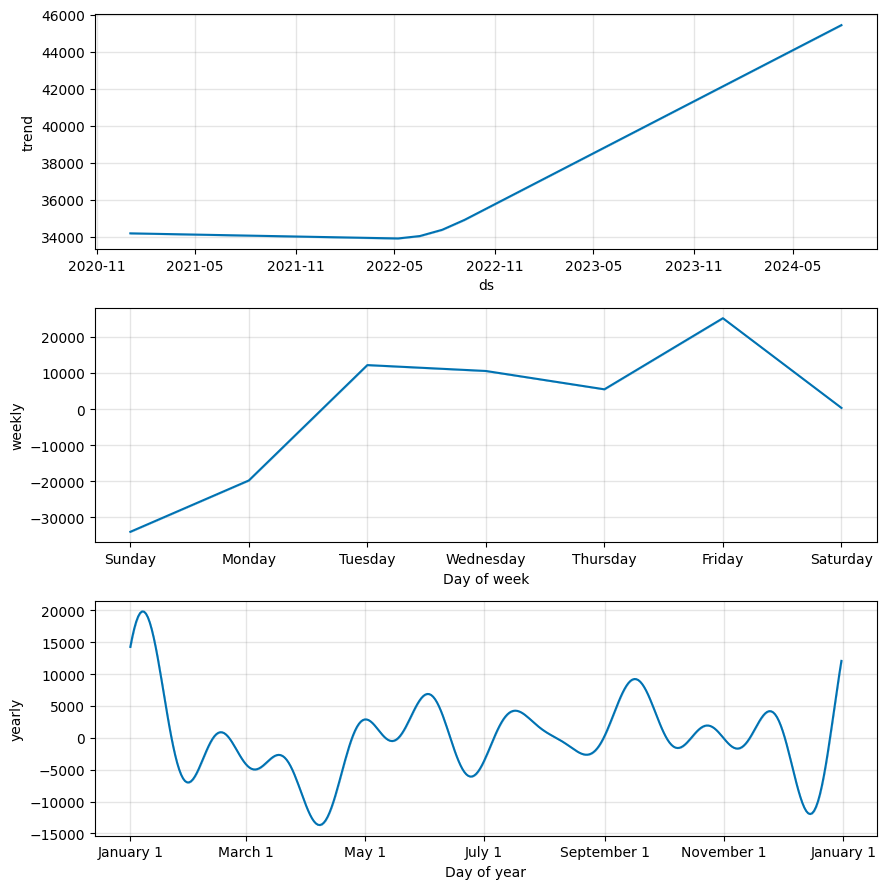

In [14]:
# Visualiser les prévisions
fig1 = model.plot(forecast)
plt.show()

# Visualiser les composantes de la prévision
fig2 = model.plot_components(forecast)
plt.show()

In [15]:
# Fusionner les données lissées et les prévisions sur la colonne 'ds'
df_merged = pd.merge(df_aggregated[['ds', 'y']], forecast[['ds', 'yhat']], on='ds')

# Calculer les métriques
mae = mean_absolute_error(df_merged['y'], df_merged['yhat'])
rmse = mean_squared_error(df_merged['y'], df_merged['yhat'], squared=False)
mape = (abs((df_merged['y'] - df_merged['yhat']) / df_merged['y']).replace([float('inf'), -float('inf')], 0)).mean() * 100

# Afficher les métriques
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 21883.12
Root Mean Squared Error (RMSE): 31833.11
Mean Absolute Percentage Error (MAPE): 2872.75%


C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
